In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [7]:
image_path = "images/"
keypoints_path = "keypoints/"
descriptors_path = "descriptors/"

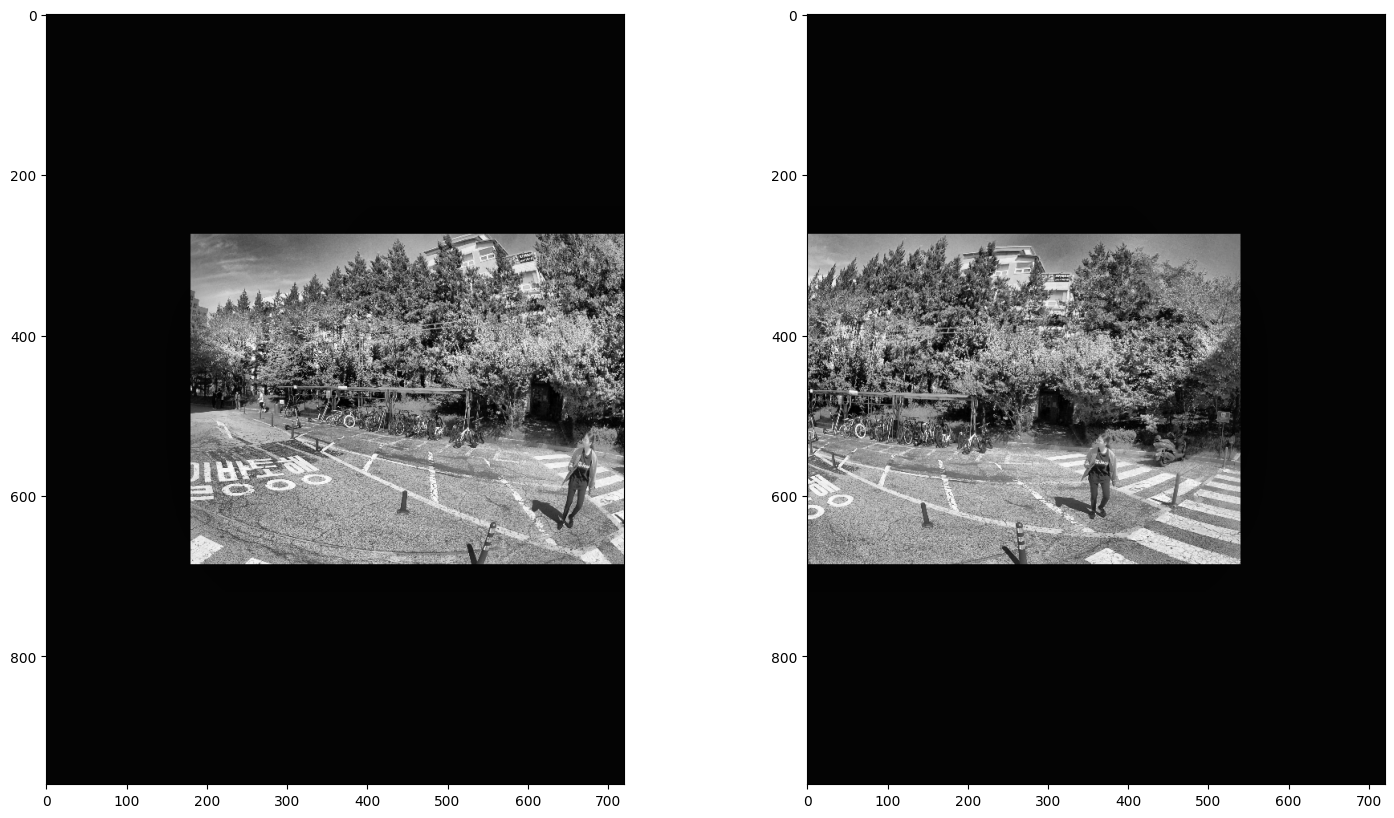

In [8]:
imgLeft0 = cv2.imread(image_path+"imageLeft_0.png", cv2.IMREAD_GRAYSCALE)
imgRight0 = cv2.imread(image_path+"imageRight_0.png", cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(18, 10))
plt.subplot(1,2,1)
plt.imshow(imgLeft0, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(imgRight0, cmap='gray')
plt.show()

In [16]:
orb = cv2.ORB_create(nfeatures=30000, scaleFactor=1.2, nlevels=15, scoreType=cv2.ORB_FAST_SCORE, fastThreshold=20)

kp_left, desc_left = orb.detectAndCompute(imgLeft0, None)
kp_right, desc_right = orb.detectAndCompute(imgRight0, None)

print("left keypoints:", len(kp_left))
print("right keypoints:", len(kp_right))

left keypoints: 20845
right keypoints: 20863


In [83]:
orbslam3_kp_left = []
with open(keypoints_path + "frameLeft0.txt", 'r') as f:
    header = f.readline()  # header
    orbslam3_kp_left_lines = f.readlines()

    for kp in orbslam3_kp_left_lines:
        kp_list = kp.split(' ')
        kp_angle, kp_class_id, kp_octave, kp_pos_x, kp_pos_y, kp_response, kp_size = kp_list
        keypoint = cv2.KeyPoint(x=float(kp_pos_x[1:-1]),
                                y=float(kp_pos_y[:-1]),
                                size=float(kp_size),
                                angle=float(kp_angle),
                                response=float(kp_response),
                                octave=int(kp_octave),
                                class_id=int(kp_class_id))
        orbslam3_kp_left.append(keypoint)
    
orbslam3_kp_right = []
with open(keypoints_path + "frameRight0.txt", 'r') as f:
    header = f.readline()  # header
    orbslam3_kp_right_lines = f.readlines()

    for kp in orbslam3_kp_right_lines:
        kp_list = kp.split(' ')
        kp_angle, kp_class_id, kp_octave, kp_pos_x, kp_pos_y, kp_response, kp_size = kp_list
        keypoint = cv2.KeyPoint(x=float(kp_pos_x[1:-1]),
                                y=float(kp_pos_y[:-1]),
                                size=float(kp_size),
                                angle=float(kp_angle),
                                response=float(kp_response),
                                octave=int(kp_octave),
                                class_id=int(kp_class_id))
        orbslam3_kp_right.append(keypoint)

print("orbslam3 left keypoints:", len(orbslam3_kp_left))
print("orbslam3 right keypoints:", len(orbslam3_kp_right))

orbslam3 left keypoints: 21543
orbslam3 right keypoints: 21645


good matches: 2598


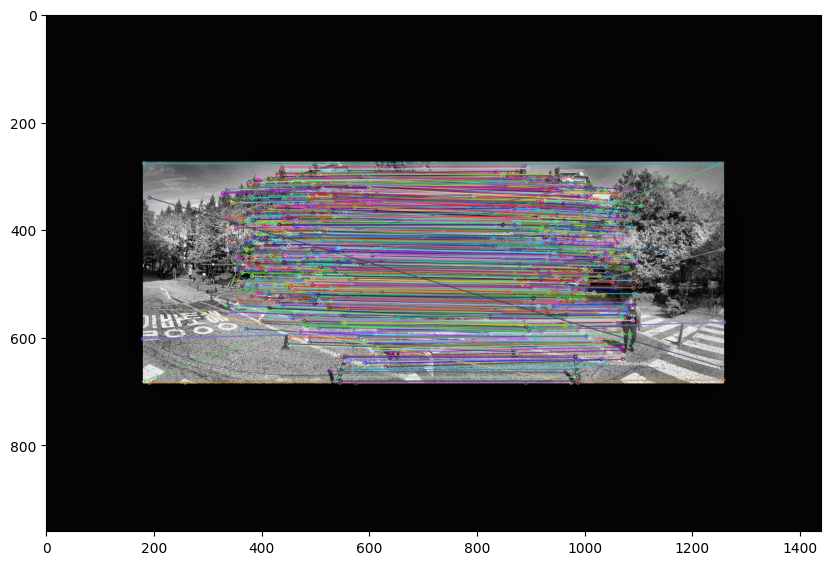

In [34]:
bfMatcher = cv2.BFMatcher(cv2.NORM_HAMMING)

matches = bfMatcher.knnMatch(desc_left, desc_right, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append([m])

print("good matches:", len(good))

# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(imgLeft0,kp_left,imgRight0,kp_right,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(10,8))
plt.imshow(img3)
plt.show()

In [37]:
m_idx = 0
good_m = good[m_idx][0]
print(good_m.queryIdx, good_m.trainIdx, good_m.imgIdx, good_m.distance)

17 2855 0 35.0


In [39]:
desc_left[16]

array([ 54, 151, 172, 136, 143,  53, 152, 206, 142,  87, 152, 183, 128,
        44,  62, 139, 205, 211, 219, 181, 158, 105, 127, 241,  25,  18,
       218, 223, 213,  93, 157,  85], dtype=uint8)

In [93]:
fs_left = cv2.FileStorage(descriptors_path + "frameLeft0.yml", cv2.FileStorage_READ)
fs_right = cv2.FileStorage(descriptors_path + "frameRight0.yml", cv2.FileStorage_READ)

orbslam3_desc_left = fs_left.getNode('descriptorLeft').mat()
orbslam3_desc_right = fs_right.getNode('descriptorRight').mat()
print("orbslam3 left descriptor shape:", orbslam3_desc_left.shape)
print("orbslam3 right descriptor shape:", orbslam3_desc_right.shape)

orbslam3 left descriptor shape: (21543, 32)
orbslam3 right descriptor shape: (21645, 32)


In [94]:
# Match left descriptors
left_matches = bfMatcher.knnMatch(desc_left, orbslam3_desc_left, k=2)

m_left, n_left = left_matches[0]

print(m_left.distance)
print(desc_left[m_left.queryIdx])
print(orbslam3_desc_left[m_left.trainIdx])

print(n_left.distance)
print(desc_left[n_left.queryIdx])
print(orbslam3_desc_left[n_left.trainIdx])
print("===========================================")
# Match right descriptors
right_matches = bfMatcher.knnMatch(desc_right, orbslam3_desc_right, k=2)

m_right, n_right = right_matches[0]

print(m_right.distance)
print(desc_right[m_right.queryIdx])
print(orbslam3_desc_right[m_right.trainIdx])

print(n_right.distance)
print(desc_right[n_right.queryIdx])
print(orbslam3_desc_right[n_right.trainIdx])

10.0
[ 78 205 160 190 153 212  30 174 190 183  12   1 236 231  99 194 211 127
 185 214  86  72 250 251 239 119 207  61 146 119 141  74]
[ 78 205 160 190 153 212  62 174 191 183  12   1 236 254  99 194 209 127
 185 215 118  72 218 251 239 119 207  63 146 119 141  74]
55.0
[ 78 205 160 190 153 212  30 174 190 183  12   1 236 231  99 194 211 127
 185 214  86  72 250 251 239 119 207  61 146 119 141  74]
[206 169 184 254 217 212 118 207 187 181 132  25 236 251  75 210 193 251
 249 208 122  75 218 243 255 247 159 123 146  84 175 138]
9.0
[ 51   6 104  79  83 186 106  74 115  69 109 135 107  40 159 252 120 142
 130 140 142 178 125 255  22 127 144   3 255 199 122 220]
[ 51   6 104  79  83 186 234  74 115  69 125 135 107  40 158 220 122 142
 130 140 158 186 125 255  22 126 144   3 255 135 122 220]
59.0
[ 51   6 104  79  83 186 106  74 115  69 109 135 107  40 159 252 120 142
 130 140 142 178 125 255  22 127 144   3 255 199 122 220]
[ 43  36 224  77  93  59 194  15  83 227 253 138 107 104 158 180

In [95]:
# match left & right (ORB-SLAM3 descriptors)
orbslam3_matches = bfMatcher.knnMatch(orbslam3_desc_left, orbslam3_desc_right, k=2)

orbslam3_good = []
for m, n in orbslam3_matches:
    if (m.distance < n.distance * 0.7):
        orbslam3_good.append(m)

print("orbslam3 matches length:", len(orbslam3_good))

orbslam3 matches length: 2182


In [102]:
os3_m, os3_n = orbslam3_matches[0]

print(os3_m.distance)
print(orbslam3_desc_left[os3_m.queryIdx])
print(orbslam3_desc_right[os3_m.trainIdx])
print("============================================")
print(os3_n.distance)
print(orbslam3_desc_left[os3_n.queryIdx])
print(orbslam3_desc_right[os3_n.trainIdx])

49.0
[127  25 110 174  13 157 218 112 141 196 188 143 107 204  55 130 236 225
 255 199 141  35  82 253 211 217 203  25  91  47 120  90]
[246  74 236 158  13  85 222 100 141 198 128  15 106 204  55 139 232 225
 251 199 204  39  86 232 243   3 205  57  81  62 124  90]
56.0
[127  25 110 174  13 157 218 112 141 196 188 143 107 204  55 130 236 225
 255 199 141  35  82 253 211 217 203  25  91  47 120  90]
[118  89 122 236  79 220 254  96 237   6 244  11 106 222  55  94 232 241
 255 227  76  35  50 233 147 249 202  27 119  63 126 198]


In [103]:
print(os3_m.queryIdx, os3_m.trainIdx)

0 1508


In [104]:
os3_m = orbslam3_good[0]

print(os3_m.distance)
print(orbslam3_desc_left[os3_m.queryIdx])
print(orbslam3_desc_right[os3_m.trainIdx])
print(os3_m.queryIdx, os3_m.trainIdx)

29.0
[  3 149 115  69 242  14 191  53 104 105 122  96 189  62 132  48 182  23
  86  40 241 184  49  78  37 188  62 128  73 210 227 185]
[  1 157  91  71 242 142 167 183 104  73 122 100 180  63 132 112 166  51
  22  72 241 184  48 111  36 188  62 128  72 194 195 185]
127 20421


In [106]:
# Stereo Descriptors
fs_stereo_left = cv2.FileStorage(descriptors_path + "frameStereoLeft0.yml", cv2.FileStorage_READ)
fs_stereo_right = cv2.FileStorage(descriptors_path + "frameStereoRight0.yml", cv2.FileStorage_READ)

orbslam3_desc_stereo_left = fs_stereo_left.getNode('descriptorStereoLeft').mat()
orbslam3_desc_stereo_right = fs_stereo_right.getNode('descriptorStereoRight').mat()
print("orbslam3 Stereo left descriptor shape:", orbslam3_desc_stereo_left.shape)
print("orbslam3 Stereo right descriptor shape:", orbslam3_desc_stereo_right.shape)

orbslam3 Stereo left descriptor shape: (14822, 32)
orbslam3 Stereo right descriptor shape: (14321, 32)


In [107]:
# match Stereo left & Stereo right (ORB-SLAM3 descriptors)
orbslam3_Stereo_matches = bfMatcher.knnMatch(orbslam3_desc_stereo_left, orbslam3_desc_stereo_right, k=2)

orbslam3_Stereo_good = []
for m, n in orbslam3_Stereo_matches:
    if (m.distance < n.distance * 0.7):
        orbslam3_Stereo_good.append(m)

print("orbslam3 matches length:", len(orbslam3_Stereo_good))

orbslam3 matches length: 2171
